# Introduction

Following the American Revolutionary war in 1787 when the United States was only a loose collection of states, three of the founders, namely Alexander Hamilton, James Madison, and John Jay published a series of 85 essays known as **Federalist Paper** where they argue for uniting the states under a centralized government based on representative democracy and ractifying the United States Constitution.

However, 11 of these papers have disputed authorship and remain a topic of debate. In this project, I utilize a language model that Microsoft developed called Deberta to determine the autorship on the disputed papers.

# Data Preprocessing

Currently, all the essays are in separate text files under one of the following directories: HAMILTON, MADISON, JAY, and DISPUTED indicating whether the authorship is known or not.

In [ ]:
from pathlib import Path
# Put the directory path will all the sub-folders of data
base_dir = Path("")
hamilton_dir = base_dir / "HAMILTON"
madison_dir = base_dir / "MADISON"
jay_dir = base_dir / "JAY"
disputed_dir = base_dir / "DISPUTED"

I use `LangChain` library to organize the text files into two json files with relevant information.

1. `train.json`: Training papers with known authorship that used for training the language model for classifcation.
2. `test.json`: Test (disputed papers) where we determine the authorship with the help of the model.

In [ ]:
!pip install langchain unstructured -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [ ]:
from langchain_community.document_loaders import DirectoryLoader

dir_paths = [hamilton_dir, madison_dir, jay_dir, disputed_dir]
docs = [DirectoryLoader(dir, glob="*.txt", use_multithreading=True).load()  for dir in dir_paths]
docs = [item  for l in docs for item in l]

In [ ]:
train = []
test = []

for d in docs:
  content = d.page_content
  author, paper_num = file_path = d.metadata["source"].split("/")[-2:]
  if author in {"HAMILTON", "MADISON", "JAY"}:
    train.append({"content": content, "author": author, "paper_num": paper_num})
  else:
    test.append({"content": content, "author": author, "paper_num": paper_num})

In [ ]:
train_json_path = base_dir / "train.json"
test_json_path = base_dir / "test.json"

In [ ]:
import json

def write_to_json(data, file_name):
  with open(file_name, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

write_to_json(train, train_json_path)
write_to_json(test, test_json_path)

# Data Preparation for training

The rest of the notebook use `HuggingFace` library for cleaning and training the model.

In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, DatasetDict, ClassLabel, Features, Value, Dataset

In [ ]:
dataset = load_dataset('json',
                       data_files={'train': str(train_json_path),
                                   'test': str(test_json_path)})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['author', 'paper_num', 'content'],
        num_rows: 71
    })
    test: Dataset({
        features: ['author', 'paper_num', 'content'],
        num_rows: 11
    })
})

Defining a ClassLabel where the index of the label correspond to the author. We create a label with numerical values instead of string. This is a necessary step for our training tasks.

In [ ]:
class_label_feature = ClassLabel(num_classes=3, names=["HAMILTON", "MADISON", "JAY"])

In [ ]:
# Create a Label Column in trained dataset
train_label = dataset['train'].map(
    lambda p: {'labels': class_label_feature.str2int(p["author"])})

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

In [ ]:
features = train_label.features
features["labels"] = class_label_feature

In [ ]:
modified_train_dataset = train_label.cast(features)

Casting the dataset:   0%|          | 0/71 [00:00<?, ? examples/s]

In [ ]:
modified_train_dataset.features

{'author': Value(dtype='string', id=None),
 'paper_num': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['HAMILTON', 'MADISON', 'JAY'], id=None)}

For evaluation purposes, I set aside 14% of the documents as validation dataset.

In [ ]:
train_val_split = modified_train_dataset.train_test_split(test_size=0.14,
                                                  stratify_by_column='labels')

In [ ]:
new_dataset = DatasetDict(
    {'train': train_val_split['train'],
     'validation': train_val_split['test'],
     'test': dataset['test']}
)

We now have dataset with three splits.

In [ ]:
new_dataset

DatasetDict({
    train: Dataset({
        features: ['author', 'paper_num', 'content', 'labels'],
        num_rows: 61
    })
    validation: Dataset({
        features: ['author', 'paper_num', 'content', 'labels'],
        num_rows: 10
    })
    test: Dataset({
        features: ['author', 'paper_num', 'content'],
        num_rows: 11
    })
})

Since each essay is very long and exceed the length of input limit to the model, we will have to break down each essays into separate chunks. At the end, we will use voting of the class from each chunk to get the final predictions of author on each paper.

In [ ]:
!pip install -U accelerate
!pip install -U transformers[sentencepiece]

In [ ]:
from transformers import AutoTokenizer
import numpy as np

In [ ]:
model_name = "microsoft/deberta-v3-small"

In [ ]:
sample = new_dataset['train'][:2]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokens = tokenizer(sample['content'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
print(len(tokens['input_ids'][0]), " ", len(tokens['input_ids'][1]))

2354   2554


In [ ]:
def chunk_document(document, max_length=500, overlap=50):
  """
  chunk_document takes each document in the dataset and returns a list
  where the document is broken down into chunks to fit the context window.
  """
  tokens = tokenizer.tokenize(document)
  chunk_size = max_length - overlap
  num_tokens = len(tokens)
  num_chunks = int(np.ceil((num_tokens- overlap) / (chunk_size - overlap)))

  # print(f"No of tokens: {num_tokens}, No. of Chunks: {num_chunks}")
  chunks = []
  for i in range(num_chunks):
    start = i * (chunk_size-overlap)
    end = start + chunk_size
    chunk = tokenizer.convert_tokens_to_string(tokens[start:end])
    chunks.append(chunk)

  return chunks

In [ ]:
chunks = chunk_document(sample['content'])
[len(c) for c in chunks]

[2434, 2347, 2194, 2324, 2307, 2328, 2353, 2355, 2352, 2494, 2284, 2394, 519]

In [ ]:
def create_chunk_dataset(dataset):
  new_data = {
      'author': [],
      'paper_num': [],
      'labels': [],
      'content': [],
      'content_chunk': []
  }
  for example in dataset:
    chunks = chunk_document(example['content'])
    for chunk in chunks:
      new_data['author'].append(example["author"])
      new_data['paper_num'].append(example['paper_num'])
      new_data['labels'].append(example.get("labels", None))
      new_data['content'].append(example['content'])
      new_data['content_chunk'].append(chunk)
  return new_data

In [ ]:
new_train_data = create_chunk_dataset(new_dataset['train'])
new_val_data = create_chunk_dataset(new_dataset['validation'])
new_test_data = create_chunk_dataset(new_dataset['test'])

In [ ]:
new_train_dataset = Dataset.from_dict(new_train_data)
new_val_dataset = Dataset.from_dict(new_val_data)
new_test_dataset = Dataset.from_dict(new_test_data)

final_dataset = DatasetDict(
    {
        'train': new_train_dataset,
        'validation': new_val_dataset,
        'test': new_test_dataset
    }
)

In [ ]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['author', 'paper_num', 'labels', 'content', 'content_chunk'],
        num_rows: 435
    })
    validation: Dataset({
        features: ['author', 'paper_num', 'labels', 'content', 'content_chunk'],
        num_rows: 57
    })
    test: Dataset({
        features: ['author', 'paper_num', 'labels', 'content', 'content_chunk'],
        num_rows: 68
    })
})

# Tokenization

Now that the dataset is finally ready, let's tokenize the entire dataset.
Although not necessary, I will re-import and reinstantiate everything here again.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

Let's define a function which will tokenizes our inputs. Here, we need to pass the appropriate features to the tokenizer from our dataset (i.e. our content that has been broken down into smaller chunks `chunk_content`).

In [ ]:
def token_func(sample): return tokenizer(sample["content_chunk"])

To run tokenization on a batch of samples from the dataset and speed up the process, we can set the `batched` argument to `True` when mapping.

In [ ]:
tokenized_datasets = final_dataset.map(token_func, batched=True)

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

It adds three new columns to our dataset:

1. `input_ids`:
2. `token_type_ids`:
3. `attention_mask`:

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['author', 'paper_num', 'labels', 'content', 'content_chunk', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 435
    })
    validation: Dataset({
        features: ['author', 'paper_num', 'labels', 'content', 'content_chunk', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 57
    })
    test: Dataset({
        features: ['author', 'paper_num', 'labels', 'content', 'content_chunk', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 68
    })
})

# Metrics & Evaluation

Since this is a classification tasks, I will focus on two metrics here:

1. Accuracy
2. F-1

Hugging Face's Trainer API, which I will use to fine-tune the model, can evaluate the metrics for us during the training if we provide it with the function returning a dictionary mapping to metrics we want.

That function receives an object with two attributes during evaluation:

1. `label_ids`: The ground truth for each example
2. `predictions`: The model's output of shape `(number_of_examples`, `number_of_classes)`

Thus, when extracting the prediction, we should get the maximum logit values across the last dimension to get our actual model prediction for a sample. To compare with the label, we then have to get our prediction's index with `argmax` function.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  return {'acc': acc, "f1": f1}

# Training the Model

We begin by defining the training arugments:

First, we select a small batch size to fit on GPU, the number of times we want to train and a small learning rate.

In [ ]:
bs, epochs, lr = 15, 12, 4e-5

Second, we can specify the training arugments.

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

In [ ]:
args = TrainingArguments(
    'outputs',
    learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
    fp16=True, evaluation_strategy="epoch", logging_strategy="steps",
    logging_steps=1, per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs, num_train_epochs=epochs, weight_decay=0.1,
    report_to="none"
)

Third, we can call the `Trainer` API to fine-tune the model for our classification task.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.weight', 'pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(model=model, args=args,
                  train_dataset=tokenized_datasets['train'],
                  eval_dataset=tokenized_datasets["validation"],
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer
                  )

Now we start training.

Overall, the training & validation loss have consistently decrease and the both the accuracy and f-1 score are also quite satisfactory.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Acc,F1
1,1.132100,0.889479,0.666667,0.533333
2,0.991500,0.820652,0.666667,0.533333
3,0.255900,1.020421,0.666667,0.533333
4,0.591900,0.686901,0.719298,0.641910
5,0.452600,0.578237,0.824561,0.785880
6,0.037900,0.591561,0.824561,0.785880
7,0.056200,0.690024,0.877193,0.867961
8,0.007700,0.794462,0.842105,0.820698
9,0.012700,0.479466,0.894737,0.888094
10,0.006900,0.390611,0.912281,0.910415


TrainOutput(global_step=348, training_loss=0.34436321575810125, metrics={'train_runtime': 180.6814, 'train_samples_per_second': 28.891, 'train_steps_per_second': 1.926, 'total_flos': 610693120372770.0, 'train_loss': 0.34436321575810125, 'epoch': 12.0})

# Error Analysis and Validation Dataset Evaluation

Let's understand where the model is making mistakes. First, let's get a mapping of index to author.

In [ ]:
val_dataset = tokenized_datasets["validation"]
author_map = {}

for d in val_dataset:
    author, label = d['author'], d['labels']
    if label not in author_map:
        author_map[label] = author

    if len(author_map) == 3:
        break

author_map

{2: 'JAY', 0: 'HAMILTON', 1: 'MADISON'}

In [ ]:
label_names = [author_map[i] for i in range(3)]
label_names

['HAMILTON', 'MADISON', 'JAY']

**Confusion Matrix**

We see that the model often make the mistake of thinking it's Hamilton on parts of the essay when it's actually written by Madison.

57


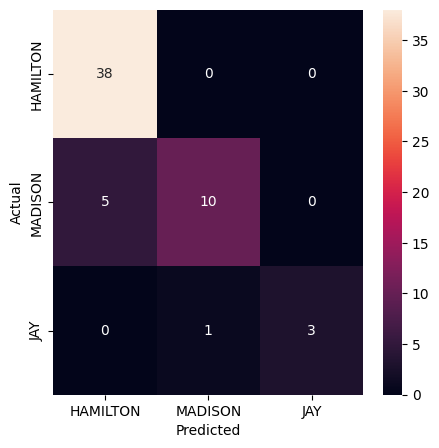

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    cm, annot=True, fmt="d", xticklabels=label_names,
    yticklabels=label_names
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Here are the parts of the essays from the paper where the model is wrong.

In [ ]:
import pandas as pd
true_author_labels = [author_map[tl] for tl in true_labels]
pred_author_labels = [author_map[pl] for pl in pred_labels]
val_results = pd.DataFrame(
    {
        'Paper Num': val_dataset['paper_num'],
        'True Author': true_author_labels,
        'Predicted Author': pred_author_labels,
        'Paragraph': val_dataset['content_chunk']
    }
)

errors = val_results[val_results['True Author'] != val_results['Predicted Author']]
with pd.option_context('display.max_colwidth', None):
  display(errors)

,Paper Num,True Author,Predicted Author,Paragraph
2,paper_5.txt,JAY,MADISON,". Both those passions would lead them to countenance, if not to promote, whatever might promise to diminish her importance; and would also restrain them from measures calculated to advance or even to secure her prosperity. Much time would not be necessary to enable her to discern these unfriendly dispositions. She would soon begin, not only to lose confidence in her neighbors, but also to feel a disposition equally unfavorable to them. Distrust naturally creates distrust, and by nothing is good-will and kind conduct more speedily changed than by invidious jealousies and uncandid imputations, whether expressed or implied. The North is generally the region of strength, and many local circumstances render it probable that the most Northern of the proposed confederacies would, at a period not very distant, be unquestionably more formidable than any of the others. No sooner would this become evident than the NORTHERN HIVE would excite the same ideas and sensations in the more southern parts of America which it formerly did in the southern parts of Europe. Nor does it appear to be a rash conjecture that its young swarms might often be tempted to gather honey in the more blooming fields and milder air of their luxurious and more delicate neighbors. They who well consider the history of similar divisions and confederacies will find abundant reason to apprehend that those in contemplation would in no other sense be neighbors than as they would be borderers; that they would neither love nor trust one another, but on the contrary would be a prey to discord, jealousy, and mutual injuries; in short, that they would place us exactly in the situations in which some nations doubtless wish to see us, viz., FORMIDABLE ONLY TO EACH OTHER. From these considerations it appears that those gentlemen are greatly mistaken who suppose that alliances offensive and defensive might be formed between these confederacies, and would produce that combination and union of wills of arms and of resources, which would be necessary to put and keep them in a formidable state of defense against foreign enemies. When did the independent states, into which Britain and Spain were formerly divided, combine in such alliance, or unite their forces against a foreign enemy? The proposed confederacies will be DISTINCT NATIONS. Each of them would have its commerce with foreigners to regulate by distinct"
10,paper_48.txt,MADISON,HAMILTON,"everywhere extending the sphere of its activity, and drawing all power into its impetuous vortex. The founders of our republics have so much merit for the wisdom which they have displayed, that no task can be less pleasing than that of pointing out the errors into which they have fallen. A respect for truth, however, obliges us to remark, that they seem never for a moment to have turned their eyes from the danger to liberty from the overgrown and all-grasping prerogative of an hereditary magistrate, supported and fortified by an hereditary branch of the legislative authority. They seem never to have recollected the danger from legislative usurpations, which, by assembling all power in the same hands, must lead to the same tyranny as is threatened by executive usurpations. In a government where numerous and extensive prerogatives are placed in the hands of an hereditary monarch, the executive department is very justly regarded as the source of danger, and watched with all the jealousy which a zeal for liberty ought to inspire. In a democracy, where a multitude of people exercise in person the legislative functions, and are continually exposed, by their incapacity for regular deliberation and concerted measures, to the ambitious intrigues of their executive magistrates, tyranny may well be apprehended, on some favorable emergency, to start up in the same quarter. But in a representative republic, where the executive magistracy is carefully limited; both in the extent a

One post-processing step is to get the final prediction of the authors by finding the mode from all the parts of the essay that are broken down.

In [ ]:
raw_validation_results = pd.DataFrame(
    {
        'paper_num': val_dataset['paper_num'],
        'true': true_labels,
        'pred': pred_labels
    }
)

Once I did that, the accuracy on the validation dataset reaches 100%. Interesting!

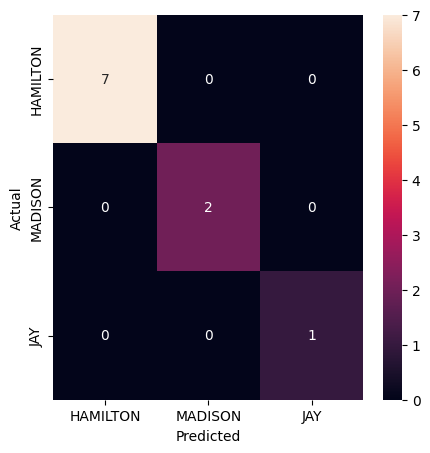

In [ ]:
result = raw_validation_results.groupby('paper_num')[['true', 'pred']].apply(lambda x: x.mode().iloc[0])

cm = confusion_matrix(result['true'], result['pred'])

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    cm, annot=True, fmt="d", xticklabels=label_names,
    yticklabels=label_names
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Deciding authors on disputed papers

In [ ]:
disputed_papers_dataset = tokenized_datasets["test"]
disputed_papers_dataset = disputed_papers_dataset.map(lambda e: {"labels": -1})
dp_predictions = trainer.predict(disputed_papers_dataset)
dp_predictions_labels = np.argmax(dp_predictions.predictions, axis=-1)

dp_results = pd.DataFrame({
     "Paper Number": disputed_papers_dataset['paper_num'],
     "Predictions": [author_map[l]  for l in dp_predictions_labels],
     "Paragraphs": disputed_papers_dataset['content_chunk']
})

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

In [ ]:
paper_author_count = {}
for paper_no, author in zip(dp_results["Paper Number"], dp_results['Predictions']):
  if paper_no not in paper_author_count:
    paper_author_count[paper_no] = {}
  paper_author_count[paper_no][author] = paper_author_count[paper_no].get(author, 0) + 1

## Verdict:

The model predicts that all the papers except paper number 55 is written by James Madison. On paper 55, the model concludes that about half of it is probably written by Madison and the other half is probably written by Hamilton.

In [ ]:
paper_author_count

{'paper_56.txt': {'MADISON': 4, 'HAMILTON': 1},
 'paper_52.txt': {'MADISON': 5, 'HAMILTON': 1},
 'paper_53.txt': {'MADISON': 5, 'JAY': 1, 'HAMILTON': 1},
 'paper_63.txt': {'MADISON': 9},
 'paper_57.txt': {'HAMILTON': 3, 'MADISON': 4},
 'paper_54.txt': {'HAMILTON': 2, 'MADISON': 4},
 'paper_62.txt': {'MADISON': 5, 'HAMILTON': 2},
 'paper_55.txt': {'MADISON': 3, 'HAMILTON': 3},
 'paper_50.txt': {'MADISON': 4},
 'paper_51.txt': {'HAMILTON': 2, 'MADISON': 4},
 'paper_49.txt': {'HAMILTON': 2, 'MADISON': 3}}

# Saving the model

In [ ]:
# Enter path to save the model
finetuned_model_path = Path("")
trainer.save_model(finetuned_model_path)
tokenizer.save_pretrained(finetuned_model_path)